In [ ]:
## @see https://www.kaggle.com/toorkp/churn-wsdm/data

In [1]:
%load_ext autoreload
%autoreload

In [2]:
import numpy as np
import pandas as pd
import time
import gc; gc.enable()
import time
import sys

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, f1_score, log_loss, confusion_matrix

from collections import Counter
from numpy.random import RandomState
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

pd.options.display.float_format = "{:.2f}".format
np.set_printoptions(precision=4)

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('modules')

from shared_functions import *
import pickle
from datetime import datetime

/home/anaconda/lib/python3.7/site-packages/pyparsing.py:2927: FutureWarning: Possible set intersection at position 3
  self.re = re.compile( self.reString )
/home/anaconda/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
# Load the pre-split data

store = pd.HDFStore('/home/dissertation/data/base_abt_split.h5')
X_train, X_test, y_train, y_test = store['X_train'], store['X_test'], store['y_train'], store['y_test']
store.close()

# Drop msno from the dataset
X_train.drop(['msno', 'registration_init_time', 'registration_init_time_dt'], inplace=True, axis=1)
X_test.drop(['msno', 'registration_init_time', 'registration_init_time_dt'], inplace=True, axis=1)

print("Train Shape:", X_train.shape, y_train.shape)
print("Train Shape:", X_test.shape, y_test.shape)
X_train.head()

Train Shape: (600803, 13) (600803,)
Train Shape: (257487, 13) (257487,)


,city,bd,registered_via,total_order,payment_method_id_mode,payment_method_id_count,payment_plan_days_mode,payment_plan_days_mean,plan_list_price_mean,plan_lifetime_value,is_auto_renew_mode,transaction_date_max,cancel_times
703741,4,32,3,22,33,1,30,21.82,108.36,2384.00,True,20170228,0
228194,13,33,3,19,39,1,30,28.58,141.16,2682.00,True,20170131,0
735733,15,22,3,17,40,3,30,30.00,158.12,2688.00,True,20170210,4
774256,1,0,7,26,41,1,30,28.85,143.27,3725.00,True,20170205,0
282188,1,0,7,27,41,1,30,28.89,132.00,3564.00,True,20170216,1


In [8]:
RANDOM_STATE = 42 
CV_ITER = None
SCORING_METRIC = autosklearn.metrics.recall
BASE_NAME = "askbasic_" + str(CV_ITER) + "cv_" + str(SCORING_METRIC)
N_JOBS = 8
## Time periods to train for in minutes
# TIME_PERIODS = [0.25, 0.5, 1, 2, 3, 4]
TIME_PERIODS = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]

## Set the list of the categorical columns in the dataset
cat_col = ['city', 'registered_via', 'payment_method_id_mode']

df_cols = X_train.columns
feat_types =  ['Categorical' if col in cat_col else 'Numerical' for col in df_cols]

classifiers = []

## Each entry in the list is a Tuple of
##   [ModelName, Model, HyperParams, ScoringMetric]    
for period in TIME_PERIODS:
    classifiers.append(
        ('ASKLEARN_{}_'.format(str(period)) + BASE_NAME,                        ## ModelName
         autosklearn.classification.AutoSklearnClassifier(                      ## Model  
                time_left_for_this_task=int(60*period), 
                n_jobs=N_JOBS,
                include_estimators=["random_forest", "decision_tree", "adaboost", "gaussian_nb",
                                    "liblinear_svc", "xgradient_boosting"], 
                exclude_estimators=None,
                include_preprocessors=["no_preprocessing", ], 
                exclude_preprocessors=None,
                ml_memory_limit = 3072*6), 
         {},                                                                    ## HyperParams
         SCORING_METRIC)                                                        ## ScoringMetric 
    )

In [9]:
all_metrics = pd.DataFrame()
all_results = list()

### Experiment 1.1 Baseline - Default Settings - No sampling

CPU times: user 7min 7s, sys: 1min 19s, total: 8min 26s
Wall time: 6h 26min 53s
Model Build Iteration 0
PRE-SAMPLING: (600803, 13) (600803,) Counter({0: 544661, 1: 56142})
POST-SAMPLING: (600803, 13) (600803,) Counter({0: 544661, 1: 56142})
Set the train df types correctly based on the test set
Applying normalisation to train and test sets
Categorical columns in dataset ['city', 'registered_via', 'payment_method_id_mode']
Categorical columns in dataset ['city', 'registered_via', 'payment_method_id_mode']
X_train:  (600803, 68) (600803, 1)
X_test:  (257487, 68) (257487, 1)


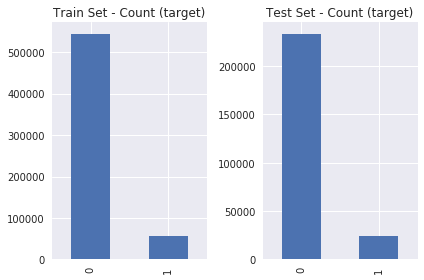

Training ASKLEARN_10_askbasic_Nonecv_recall classifier
No params set, using Standard training


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-08 04:46:31,951:EnsembleBuilder(1791095845):7252846721f7b1269624158f4c03cc3b] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 04:46:32,119:EnsembleBuilder(1791095845):7252846721f7b1269624158f4c03cc3b] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-08 04:46:34,165:EnsembleBuilder(1791095845):7252846721f7b1269624158f4c03cc3b] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-08 04:46:36,403:EnsembleBuilder(1791095845):7252846721f7b1269624158f4c03cc3b] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-08 04:46:38,474:EnsembleBuilder(1791095845):7252846721f7b1269624158f4c03cc3b] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 04:46:40,504:EnsembleBuilder(1791095845):7252846721f7b1269624158f4c03cc3b] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 04:46:42,532:EnsembleBuilder(1791095845):7252846721f7b1269624158f4c03cc3b] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 04:46:44,555:EnsembleBuilder(1791095845):7252846721f7b1269624158f4c03cc3b] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 04:46:46,564:EnsembleBuilder(1791095845):7252846721f7b1269624158f4c03cc3b] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 04:46:48,576:EnsembleBuilder(1791095845):7252846721f7b1269624158f4c03cc3b] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 04:46:50,612:EnsembleBuilder(1791095845):7252846721f7b1269624158f4c03cc3b] No models better than

/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-08 04:46:58,749:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-08-08 04:46:58,749:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

-1
['/tmp/autosklearn_tmp_26421_3205/.auto-sklearn/ensembles/1791095845.0000000000.ensemble', '/tmp/autosklearn_tmp_26421_3205/.auto-sklearn/ensembles/1791095845.0000000001.ensemble', '/tmp/autosklearn_tmp_26421_3205/.auto-sklearn/ensembles/1791095845.0000000002.ensemble', '/tmp/autosklearn_tmp_26421_3205/.auto-sklearn/ensembles/1791095845.0000000003.ensemble', '/tmp/autosklearn_tmp_26421_3205/.auto-sklearn/ensembles/1791095845.0000000004.ensemble', '/tmp/autosklearn_tmp_26421_3205/.auto-sklearn/ensembles/1791095845.0000000005.ensemble', '/tmp/autosklearn_tmp_26421_3205/.auto-sklearn/ensembles/1791095845.0000000006.ensemble', '/tmp/autosklearn_tmp_26421_3205/.auto-sklearn/ensembles/1791095845.0000000007.ensemble', '/tmp/autosklearn_tmp_26421_3205/.auto-sklearn/ensembles/1791095845.0000000008.ensemble', '/tmp/autosklearn_tmp_26421_3205/.auto-sklearn/ensembles/1791095845.0000000009.ensemble', '/tmp/autosklearn_tmp_26421_3205/.auto-sklearn/ensembles/1791095845.0000000010.ensemble', '/tmp/

/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-08 04:57:16,481:EnsembleBuilder(1791095845):7252846721f7b1269624158f4c03cc3b] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 04:57:16,611:EnsembleBuilder(1791095845):7252846721f7b1269624158f4c03cc3b] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-08 04:57:18,740:EnsembleBuilder(1791095845):7252846721f7b1269624158f4c03cc3b] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-08 04:57:20,899:EnsembleBuilder(1791095845):7252846721f7b1269624158f4c03cc3b] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-08 04:57:23,013:EnsembleBuilder(1791095845):7252846721f7b1269624158f4c03cc3b] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 04:57:25,044:EnsembleBuilder(1791095845):7252846721f7b1269624158f4c03cc3b] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 04:57:27,072:EnsembleBuilder(1791095845):7252846721f7b1269624158f4c03cc3b] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 04:57:29,084:EnsembleBuilder(1791095845):7252846721f7b1269624158f4c03cc3b] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 04:57:31,127:EnsembleBuilder(1791095845):7252846721f7b1269624158f4c03cc3b] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 04:57:33,144:EnsembleBuilder(1791095845):7252846721f7b1269624158f4c03cc3b] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 04:57:35,172:EnsembleBuilder(1791095845):7252846721f7b1269624158f4c03cc3b] No models better than

/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-08 04:57:42,471:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-08-08 04:57:42,471:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

KeyError: None

/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

[WARNING] [2019-08-08 05:06:58,317:EnsembleBuilder(1791095845):7252846721f7b1269624158f4c03cc3b] Memory Exception -- restart with less ensemle_nbest: 25


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

In [12]:
%%time
start = time.time()

sampler = ('None', DummySampler())

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col, auto_ml = True)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("basic, autosklearn, {0}, {1}".format(sampler[0], time.time()-start), 'Basic_Autosklearn.log')

In [13]:
all_metrics

,label,classifier,sampling_method,tn,fn,tp,fp,accuracy,precision,recall,...,log_loss,train_time,cv_time,aucroc,auprc,balanced_accuracy,cv_score_mean,cv_score_std,model_churn_cost,sample
0,ASKLEARN_10_askbasic_Nonecv_recall,AutoSklearnClassifier,ROS 1:1,209239,8023,16038,24187,0.87,0.40,0.67,...,4.32,625.18,0.00,0.84,0.56,0.78,-1,-1,8034000,0
0,ASKLEARN_15_askbasic_Nonecv_recall,AutoSklearnClassifier,ROS 1:1,203971,7320,16741,29455,0.86,0.36,0.70,...,4.93,901.96,0.00,0.84,0.57,0.78,-1,-1,8279600,0
0,ASKLEARN_20_askbasic_Nonecv_recall,AutoSklearnClassifier,ROS 1:1,209201,7351,16710,24225,0.88,0.41,0.69,...,4.24,1214.99,0.00,0.83,0.52,0.80,-1,-1,7769000,0
0,ASKLEARN_25_askbasic_Nonecv_recall,AutoSklearnClassifier,ROS 1:1,209201,7351,16710,24225,0.88,0.41,0.69,...,4.24,1511.67,0.00,0.83,0.53,0.80,-1,-1,7769000,0
0,ASKLEARN_30_askbasic_Nonecv_recall,AutoSklearnClassifier,ROS 1:1,212013,9157,14904,21413,0.88,0.41,0.62,...,4.10,1803.34,0.00,0.83,0.49,0.76,-1,-1,8210200,0
0,ASKLEARN_35_askbasic_Nonecv_recall,AutoSklearnClassifier,ROS 1:1,203685,6984,17077,29741,0.86,0.36,0.71,...,4.93,2103.12,0.00,0.86,0.57,0.79,-1,-1,8173800,0
0,ASKLEARN_40_askbasic_Nonecv_recall,AutoSklearnClassifier,ROS 1:1,211860,9145,14916,21566,0.88,0.41,0.62,...,4.12,2409.41,0.00,0.81,0.47,0.76,-1,-1,8220700,0
0,ASKLEARN_45_askbasic_Nonecv_recall,AutoSklearnClassifier,ROS 1:1,212707,9203,14858,20719,0.88,0.42,0.62,...,4.01,2699.76,0.00,0.81,0.48,0.76,-1,-1,8159200,0
0,ASKLEARN_50_askbasic_Nonecv_recall,AutoSklearnClassifier,ROS 1:1,204715,7093,16968,28711,0.86,0.37,0.71,...,4.80,3002.37,0.00,0.85,0.54,0.79,-1,-1,8114400,0
0,ASKLEARN_55_askbasic_Nonecv_recall,AutoSklearnClassifier,ROS 1:1,202032,6439,17622,31394,0.85,0.36,0.73,...,5.07,3302.67,0.00,0.86,0.54,0.80,-1,-1,8121100,0


### Experiment 1.2 Baseline - Default Settings - Oversampled training set 100%

Model Build Iteration 0
PRE-SAMPLING: (600803, 13) (600803,) Counter({0: 544661, 1: 56142})
POST-SAMPLING: (1089322, 13) (1089322,) Counter({0: 544661, 1: 544661})
Set the train df types correctly based on the test set
Applying normalisation to train and test sets
Categorical columns in dataset ['city', 'registered_via', 'payment_method_id_mode']
Categorical columns in dataset ['city', 'registered_via', 'payment_method_id_mode']
X_train:  (1089322, 68) (1089322, 1)
X_test:  (257487, 68) (257487, 1)


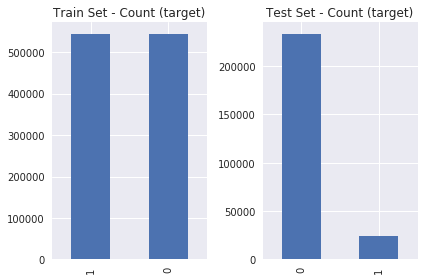

Training ASKLEARN_10_askbasic_Nonecv_recall classifier
No params set, using Standard training


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-07 22:20:48,758:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 22:20:49,417:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 22:20:51,435:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 22:20:53,474:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 22:20:55,503:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 22:20:57,516:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-07 22:20:59,718:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-07 22:21:02,226:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-07 22:21:04,405:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 22:21:06,420:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 22:21:08,436:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 22:21:10,451:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 22:21:12,462:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 22:21:14,489:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 22:21:16,512:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than

/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-07 22:22:14,523:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 22:22:18,797:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

[WARNING] [2019-08-07 22:29:27,547:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-08-07 22:29:27,547:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
-1
['/tmp/autosklearn_tmp_26421_3332/.auto-sklearn/ensembles/1791095845.0000000000.ensemble', '/tmp/autosklearn_tmp_26421_3332/.auto-sklearn/ensembles/1791095845.0000000001.ensemble', '/tmp/autosklearn_tmp_26421_3332/.auto-sklearn/ensembles/1791095845.0000000002.ensemble', '/tmp/autosklearn_tmp_26421_3332/.auto-sklearn/ensembles/1791095845.0000000003.ensemble', '/tmp/autosklearn_tmp_26421_3332/.auto-sklearn/ensembles/1791095845.0000000004.ensemble', '/tmp/autosklearn_tmp_26421_3332/.auto-sklearn/ensembles/1791095845.0000000005.ensemble', '/tmp/autosklearn_tmp_26421_3332/.auto-sklearn/ensembles/1791095845.0000000006.ensemble']
Generating test scores for ASKLEARN_10_askbasic_Nonecv_r

/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-07 22:30:39,658:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 22:30:39,896:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-07 22:30:42,132:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 22:30:44,230:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-07 22:30:46,333:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 22:30:48,510:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-07 22:30:50,696:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 22:30:52,724:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 22:30:54,736:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 22:30:56,752:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 22:30:58,780:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 22:31:00,808:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 22:31:02,831:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than

/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

[WARNING] [2019-08-07 22:37:13,029:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] Memory Exception -- restart with less ensemle_nbest: 25


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

[WARNING] [2019-08-07 22:44:54,270:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-08-07 22:44:54,270:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-08-07 22:44:58,459:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-08-07 22:44:58,459:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-08-07 22:44:58,759:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-08-07 22:44:58,759:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-08-07 22:44:59,815:smac.intensification.intensificatio

/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-07 22:45:42,335:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 22:45:42,498:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-07 22:45:44,635:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-07 22:45:46,901:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 22:45:49,051:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-07 22:45:51,166:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 22:45:53,175:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 22:45:55,208:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 22:45:57,232:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 22:45:59,261:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 22:46:01,288:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 22:46:03,368:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than

/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-07 22:46:27,644:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

[WARNING] [2019-08-07 22:54:12,455:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] Memory Exception -- restart with less ensemle_nbest: 25


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

-1
['/tmp/autosklearn_tmp_26421_8413/.auto-sklearn/ensembles/1791095845.0000000000.ensemble', '/tmp/autosklearn_tmp_26421_8413/.auto-sklearn/ensembles/1791095845.0000000001.ensemble', '/tmp/autosklearn_tmp_26421_8413/.auto-sklearn/ensembles/1791095845.0000000002.ensemble', '/tmp/autosklearn_tmp_26421_8413/.auto-sklearn/ensembles/1791095845.0000000003.ensemble', '/tmp/autosklearn_tmp_26421_8413/.auto-sklearn/ensembles/1791095845.0000000004.ensemble', '/tmp/autosklearn_tmp_26421_8413/.auto-sklearn/ensembles/1791095845.0000000005.ensemble']
Generating test scores for ASKLEARN_20_askbasic_Nonecv_recall classifier
Training ASKLEARN_25_askbasic_Nonecv_recall classifier
No params set, using Standard training


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-07 23:05:53,010:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 23:05:53,188:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 23:05:55,224:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-07 23:05:57,360:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-07 23:05:59,554:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-07 23:06:01,698:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-07 23:06:03,887:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 23:06:05,915:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 23:06:07,932:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 23:06:09,956:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 23:06:11,986:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 23:06:14,020:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 23:06:16,036:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than

/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

[WARNING] [2019-08-07 23:14:20,800:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] Memory Exception -- restart with less ensemle_nbest: 25


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-07 23:27:59,081:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-08-07 23:27:59,081:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
Process Process-61:
Traceback (most recent call last):
  File "/home/anaconda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/anaconda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/anaconda/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/

[WARNING] [2019-08-07 23:30:19,382:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-08-07 23:30:19,382:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
-1
['/tmp/autosklearn_tmp_26421_2702/.auto-sklearn/ensembles/1791095845.0000000000.ensemble', '/tmp/autosklearn_tmp_26421_2702/.auto-sklearn/ensembles/1791095845.0000000001.ensemble', '/tmp/autosklearn_tmp_26421_2702/.auto-sklearn/ensembles/1791095845.0000000002.ensemble', '/tmp/autosklearn_tmp_26421_2702/.auto-sklearn/ensembles/1791095845.0000000003.ensemble', '/tmp/autosklearn_tmp_26421_2702/.auto-sklearn/ensembles/1791095845.0000000004.ensemble', '/tmp/autosklearn_tmp_26421_2702/.auto-sklearn/ensembles/1791095845.0000000005.ensemble', '/tmp/autosklearn_tmp_26421_2702/.auto-sklearn/ensembles/1791095845.0000000006.ensemble']
Generating test scores for ASKLEARN_25_askbasic_Nonecv_r

/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

[WARNING] [2019-08-07 23:31:08,310:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 23:31:08,500:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-07 23:31:10,568:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-07 23:31:12,646:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 23:31:14,668:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 23:31:16,676:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 23:31:18,684:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 23:31:20,696:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 23:31:22,723:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-07 23:31:24,755:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than

/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-07 23:31:39,072:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

[WARNING] [2019-08-07 23:39:37,708:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] Memory Exception -- restart with less ensemle_nbest: 25


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


-1
['/tmp/autosklearn_tmp_26421_8950/.auto-sklearn/ensembles/1791095845.0000000000.ensemble', '/tmp/autosklearn_tmp_26421_8950/.auto-sklearn/ensembles/1791095845.0000000001.ensemble', '/tmp/autosklearn_tmp_26421_8950/.auto-sklearn/ensembles/1791095845.0000000002.ensemble', '/tmp/autosklearn_tmp_26421_8950/.auto-sklearn/ensembles/1791095845.0000000003.ensemble', '/tmp/autosklearn_tmp_26421_8950/.auto-sklearn/ensembles/1791095845.0000000004.ensemble', '/tmp/autosklearn_tmp_26421_8950/.auto-sklearn/ensembles/1791095845.0000000005.ensemble']
[WARNING] [2019-08-08 00:00:39,021:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-08-08 00:00:39,021:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
Generating test scores for ASKLEARN_30_askbasic_Nonecv_recall classifier
Training ASKLEARN_35_askbasic_Nonecv_recall classifier
No params set, usi

/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

[WARNING] [2019-08-08 00:01:20,009:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 00:01:20,223:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 00:01:22,252:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 00:01:24,280:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 00:01:26,311:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 00:01:28,386:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 00:01:30,404:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than

/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

[WARNING] [2019-08-08 00:07:51,711:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] Memory Exception -- restart with less ensemle_nbest: 25


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

-1
['/tmp/autosklearn_tmp_26421_9037/.auto-sklearn/ensembles/1791095845.0000000000.ensemble', '/tmp/autosklearn_tmp_26421_9037/.auto-sklearn/ensembles/1791095845.0000000001.ensemble', '/tmp/autosklearn_tmp_26421_9037/.auto-sklearn/ensembles/1791095845.0000000002.ensemble', '/tmp/autosklearn_tmp_26421_9037/.auto-sklearn/ensembles/1791095845.0000000003.ensemble', '/tmp/autosklearn_tmp_26421_9037/.auto-sklearn/ensembles/1791095845.0000000004.ensemble', '/tmp/autosklearn_tmp_26421_9037/.auto-sklearn/ensembles/1791095845.0000000005.ensemble', '/tmp/autosklearn_tmp_26421_9037/.auto-sklearn/ensembles/1791095845.0000000006.ensemble', '/tmp/autosklearn_tmp_26421_9037/.auto-sklearn/ensembles/1791095845.0000000007.ensemble']
Generating test scores for ASKLEARN_35_askbasic_Nonecv_recall classifier
Training ASKLEARN_40_askbasic_Nonecv_recall classifier
No params set, using Standard training


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-08 00:36:09,901:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 00:36:10,127:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-08 00:36:12,204:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-08 00:36:14,313:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 00:36:16,348:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-08 00:36:18,600:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-08 00:36:20,636:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-08 00:36:22,966:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 00:36:25,004:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 00:36:27,032:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-08 00:36:29,180:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 00:36:31,206:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 00:36:33,220:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 00:36:35,237:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 00:36:37,509:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 00:36:39,536:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 00:36:41,564:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than

/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

[WARNING] [2019-08-08 00:44:23,683:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] Memory Exception -- restart with less ensemle_nbest: 25


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

-1
['/tmp/autosklearn_tmp_26421_9552/.auto-sklearn/ensembles/1791095845.0000000000.ensemble', '/tmp/autosklearn_tmp_26421_9552/.auto-sklearn/ensembles/1791095845.0000000001.ensemble', '/tmp/autosklearn_tmp_26421_9552/.auto-sklearn/ensembles/1791095845.0000000002.ensemble', '/tmp/autosklearn_tmp_26421_9552/.auto-sklearn/ensembles/1791095845.0000000003.ensemble', '/tmp/autosklearn_tmp_26421_9552/.auto-sklearn/ensembles/1791095845.0000000004.ensemble', '/tmp/autosklearn_tmp_26421_9552/.auto-sklearn/ensembles/1791095845.0000000005.ensemble', '/tmp/autosklearn_tmp_26421_9552/.auto-sklearn/ensembles/1791095845.0000000006.ensemble', '/tmp/autosklearn_tmp_26421_9552/.auto-sklearn/ensembles/1791095845.0000000007.ensemble']
Generating test scores for ASKLEARN_40_askbasic_Nonecv_recall classifier
Training ASKLEARN_45_askbasic_Nonecv_recall classifier
No params set, using Standard training


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-08 01:16:21,634:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 01:16:22,012:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-08 01:16:24,202:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-08 01:16:26,453:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 01:16:28,496:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-08 01:16:30,579:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-08 01:16:32,858:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-08 01:16:34,945:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 01:16:36,962:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 01:16:38,976:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 01:16:41,004:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 01:16:43,030:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 01:16:47,730:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 01:16:49,811:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than

/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

[WARNING] [2019-08-08 01:21:56,727:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] Memory Exception -- restart with less ensemle_nbest: 25


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

[WARNING] [2019-08-08 01:38:16,649:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-08-08 01:38:16,649:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-08 01:41:33,594:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-08-08 01:41:33,594:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

[WARNING] [2019-08-08 02:00:53,415:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-08-08 02:00:53,415:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
-1
['/tmp/autosklearn_tmp_26421_4642/.auto-sklearn/ensembles/1791095845.0000000000.ensemble', '/tmp/autosklearn_tmp_26421_4642/.auto-sklearn/ensembles/1791095845.0000000001.ensemble', '/tmp/autosklearn_tmp_26421_4642/.auto-sklearn/ensembles/1791095845.0000000002.ensemble', '/tmp/autosklearn_tmp_26421_4642/.auto-sklearn/ensembles/1791095845.0000000003.ensemble', '/tmp/autosklearn_tmp_26421_4642/.auto-sklearn/ensembles/1791095845.0000000004.ensemble', '/tmp/autosklearn_tmp_26421_4642/.auto-sklearn/ensembles/1791095845.0000000005.ensemble']
Generating test scores for ASKLEARN_45_askbasic_Nonecv_recall classifier
Training ASKLEARN_50_askbasic_Nonecv_recall classifier
No params set, usi

/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-08 02:01:25,498:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 02:01:25,741:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 02:01:27,776:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-08 02:01:29,917:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 02:01:31,956:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-08 02:01:34,168:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 02:01:36,220:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-08 02:01:38,342:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-08 02:01:40,513:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 02:01:42,560:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 02:01:44,592:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 02:01:46,607:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 02:01:48,636:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 02:01:50,664:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 02:01:52,691:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than

/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

[WARNING] [2019-08-08 02:08:20,333:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] Memory Exception -- restart with less ensemle_nbest: 25


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

[WARNING] [2019-08-08 02:34:04,879:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-08-08 02:34:04,879:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

[WARNING] [2019-08-08 02:40:50,639:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-08-08 02:40:50,639:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

-1
['/tmp/autosklearn_tmp_26421_8484/.auto-sklearn/ensembles/1791095845.0000000000.ensemble', '/tmp/autosklearn_tmp_26421_8484/.auto-sklearn/ensembles/1791095845.0000000001.ensemble', '/tmp/autosklearn_tmp_26421_8484/.auto-sklearn/ensembles/1791095845.0000000002.ensemble', '/tmp/autosklearn_tmp_26421_8484/.auto-sklearn/ensembles/1791095845.0000000003.ensemble', '/tmp/autosklearn_tmp_26421_8484/.auto-sklearn/ensembles/1791095845.0000000004.ensemble']
Generating test scores for ASKLEARN_50_askbasic_Nonecv_recall classifier
Training ASKLEARN_55_askbasic_Nonecv_recall classifier
No params set, using Standard training


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-08 02:51:31,690:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 02:51:31,935:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-08 02:51:33,964:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-08 02:51:36,163:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-08 02:51:38,324:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 02:51:40,343:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 02:51:42,356:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 02:51:44,399:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 02:51:46,424:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 02:51:48,448:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 02:51:50,480:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than

/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

[WARNING] [2019-08-08 02:59:20,438:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] Memory Exception -- restart with less ensemle_nbest: 25


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-08 03:18:05,039:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-08-08 03:18:05,039:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


-1
['/tmp/autosklearn_tmp_26421_1008/.auto-sklearn/ensembles/1791095845.0000000000.ensemble', '/tmp/autosklearn_tmp_26421_1008/.auto-sklearn/ensembles/1791095845.0000000001.ensemble', '/tmp/autosklearn_tmp_26421_1008/.auto-sklearn/ensembles/1791095845.0000000002.ensemble', '/tmp/autosklearn_tmp_26421_1008/.auto-sklearn/ensembles/1791095845.0000000003.ensemble', '/tmp/autosklearn_tmp_26421_1008/.auto-sklearn/ensembles/1791095845.0000000004.ensemble', '/tmp/autosklearn_tmp_26421_1008/.auto-sklearn/ensembles/1791095845.0000000005.ensemble']
Generating test scores for ASKLEARN_55_askbasic_Nonecv_recall classifier
Training ASKLEARN_60_askbasic_Nonecv_recall classifier
No params set, using Standard training


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-08 03:46:35,547:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 03:46:35,722:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-08 03:46:37,820:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-08 03:46:39,962:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 03:46:41,992:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 03:46:44,023:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 03:46:46,032:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 03:46:48,060:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 03:46:50,090:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 03:46:52,124:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] No models better than

/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

[WARNING] [2019-08-08 03:53:53,391:EnsembleBuilder(1791095845):d5a736e3a0c2a51e7cc2f372c4a536de] Memory Exception -- restart with less ensemle_nbest: 25


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

-1
['/tmp/autosklearn_tmp_26421_1854/.auto-sklearn/ensembles/1791095845.0000000000.ensemble', '/tmp/autosklearn_tmp_26421_1854/.auto-sklearn/ensembles/1791095845.0000000001.ensemble', '/tmp/autosklearn_tmp_26421_1854/.auto-sklearn/ensembles/1791095845.0000000002.ensemble', '/tmp/autosklearn_tmp_26421_1854/.auto-sklearn/ensembles/1791095845.0000000003.ensemble', '/tmp/autosklearn_tmp_26421_1854/.auto-sklearn/ensembles/1791095845.0000000004.ensemble', '/tmp/autosklearn_tmp_26421_1854/.auto-sklearn/ensembles/1791095845.0000000005.ensemble', '/tmp/autosklearn_tmp_26421_1854/.auto-sklearn/ensembles/1791095845.0000000006.ensemble']
Generating test scores for ASKLEARN_60_askbasic_Nonecv_recall classifier


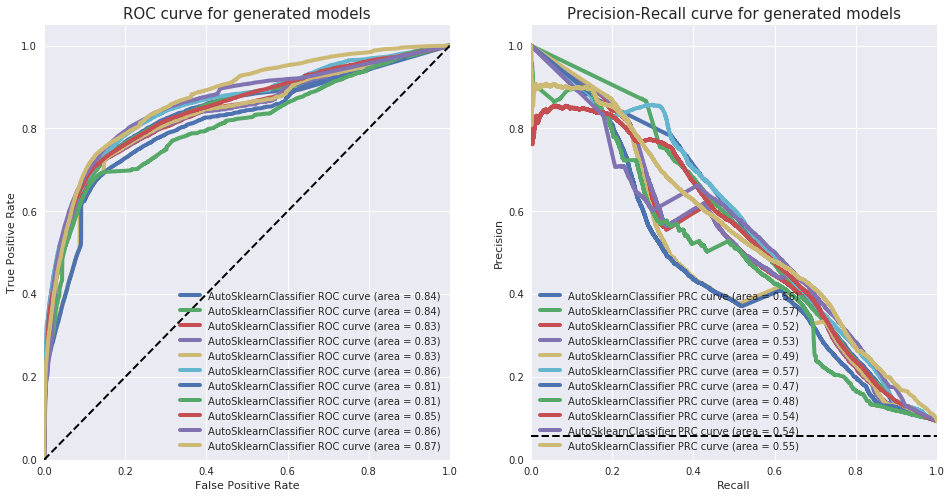

In [11]:
%%time
start = time.time()

sampler = ('ROS 1:1', RandomOverSampler(random_state=RANDOM_STATE))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col, auto_ml = True)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("basic, autosklearn, {0}, {1}".format(sampler[0], time.time()-start), 'Basic_Autosklearn.log')

In [14]:
all_metrics

,label,classifier,sampling_method,tn,fn,tp,fp,accuracy,precision,recall,...,log_loss,train_time,cv_time,aucroc,auprc,balanced_accuracy,cv_score_mean,cv_score_std,model_churn_cost,sample
0,ASKLEARN_10_askbasic_Nonecv_recall,AutoSklearnClassifier,ROS 1:1,209239,8023,16038,24187,0.87,0.40,0.67,...,4.32,625.18,0.00,0.84,0.56,0.78,-1,-1,8034000,0
0,ASKLEARN_15_askbasic_Nonecv_recall,AutoSklearnClassifier,ROS 1:1,203971,7320,16741,29455,0.86,0.36,0.70,...,4.93,901.96,0.00,0.84,0.57,0.78,-1,-1,8279600,0
0,ASKLEARN_20_askbasic_Nonecv_recall,AutoSklearnClassifier,ROS 1:1,209201,7351,16710,24225,0.88,0.41,0.69,...,4.24,1214.99,0.00,0.83,0.52,0.80,-1,-1,7769000,0
0,ASKLEARN_25_askbasic_Nonecv_recall,AutoSklearnClassifier,ROS 1:1,209201,7351,16710,24225,0.88,0.41,0.69,...,4.24,1511.67,0.00,0.83,0.53,0.80,-1,-1,7769000,0
0,ASKLEARN_30_askbasic_Nonecv_recall,AutoSklearnClassifier,ROS 1:1,212013,9157,14904,21413,0.88,0.41,0.62,...,4.10,1803.34,0.00,0.83,0.49,0.76,-1,-1,8210200,0
0,ASKLEARN_35_askbasic_Nonecv_recall,AutoSklearnClassifier,ROS 1:1,203685,6984,17077,29741,0.86,0.36,0.71,...,4.93,2103.12,0.00,0.86,0.57,0.79,-1,-1,8173800,0
0,ASKLEARN_40_askbasic_Nonecv_recall,AutoSklearnClassifier,ROS 1:1,211860,9145,14916,21566,0.88,0.41,0.62,...,4.12,2409.41,0.00,0.81,0.47,0.76,-1,-1,8220700,0
0,ASKLEARN_45_askbasic_Nonecv_recall,AutoSklearnClassifier,ROS 1:1,212707,9203,14858,20719,0.88,0.42,0.62,...,4.01,2699.76,0.00,0.81,0.48,0.76,-1,-1,8159200,0
0,ASKLEARN_50_askbasic_Nonecv_recall,AutoSklearnClassifier,ROS 1:1,204715,7093,16968,28711,0.86,0.37,0.71,...,4.80,3002.37,0.00,0.85,0.54,0.79,-1,-1,8114400,0
0,ASKLEARN_55_askbasic_Nonecv_recall,AutoSklearnClassifier,ROS 1:1,202032,6439,17622,31394,0.85,0.36,0.73,...,5.07,3302.67,0.00,0.86,0.54,0.80,-1,-1,8121100,0


### Experiment 1.3 Baseline - Default Settings - Undersampled training set

Model Build Iteration 0
PRE-SAMPLING: (600803, 13) (600803,) Counter({0: 544661, 1: 56142})
POST-SAMPLING: (112284, 13) (112284,) Counter({0: 56142, 1: 56142})
Set the train df types correctly based on the test set
Applying normalisation to train and test sets
Categorical columns in dataset ['city', 'registered_via', 'payment_method_id_mode']
Categorical columns in dataset ['city', 'registered_via', 'payment_method_id_mode']
X_train:  (112284, 68) (112284, 1)
X_test:  (257487, 68) (257487, 1)


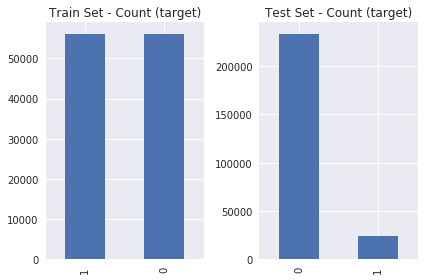

Training ASKLEARN_10_askbasic_Nonecv_recall classifier
No params set, using Standard training


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

[WARNING] [2019-08-08 09:36:16,171:EnsembleBuilder(1791095845):c909536b576c6b3891e97621d6532c5b] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 09:36:16,186:EnsembleBuilder(1791095845):c909536b576c6b3891e97621d6532c5b] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-08 09:36:18,198:EnsembleBuilder(1791095845):c909536b576c6b3891e97621d6532c5b] No models better than random - using Dummy Score!
[WARNING] [2019-08-08 09:36:20,223:EnsembleBuilder(1791095845):c909536b576c6b3891e97621d6532c5b] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

[WARNING] [2019-08-08 09:37:20,635:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-08-08 09:37:20,635:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

-1
['/tmp/autosklearn_tmp_26421_3105/.auto-sklearn/ensembles/1791095845.0000000000.ensemble', '/tmp/autosklearn_tmp_26421_3105/.auto-sklearn/ensembles/1791095845.0000000001.ensemble', '/tmp/autosklearn_tmp_26421_3105/.auto-sklearn/ensembles/1791095845.0000000002.ensemble', '/tmp/autosklearn_tmp_26421_3105/.auto-sklearn/ensembles/1791095845.0000000003.ensemble', '/tmp/autosklearn_tmp_26421_3105/.auto-sklearn/ensembles/1791095845.0000000004.ensemble', '/tmp/autosklearn_tmp_26421_3105/.auto-sklearn/ensembles/1791095845.0000000005.ensemble', '/tmp/autosklearn_tmp_26421_3105/.auto-sklearn/ensembles/1791095845.0000000006.ensemble', '/tmp/autosklearn_tmp_26421_3105/.auto-sklearn/ensembles/1791095845.0000000007.ensemble', '/tmp/autosklearn_tmp_26421_3105/.auto-sklearn/ensembles/1791095845.0000000008.ensemble', '/tmp/autosklearn_tmp_26421_3105/.auto-sklearn/ensembles/1791095845.0000000009.ensemble', '/tmp/autosklearn_tmp_26421_3105/.auto-sklearn/ensembles/1791095845.0000000010.ensemble', '/tmp/

/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

[WARNING] [2019-08-08 09:53:08,424:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-08-08 09:53:08,424:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-08 10:01:52,154:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-08-08 10:01:52,154:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

-1
['/tmp/autosklearn_tmp_26421_4364/.auto-sklearn/ensembles/1791095845.0000000000.ensemble', '/tmp/autosklearn_tmp_26421_4364/.auto-sklearn/ensembles/1791095845.0000000001.ensemble', '/tmp/autosklearn_tmp_26421_4364/.auto-sklearn/ensembles/1791095845.0000000002.ensemble', '/tmp/autosklearn_tmp_26421_4364/.auto-sklearn/ensembles/1791095845.0000000003.ensemble', '/tmp/autosklearn_tmp_26421_4364/.auto-sklearn/ensembles/1791095845.0000000004.ensemble', '/tmp/autosklearn_tmp_26421_4364/.auto-sklearn/ensembles/1791095845.0000000005.ensemble', '/tmp/autosklearn_tmp_26421_4364/.auto-sklearn/ensembles/1791095845.0000000006.ensemble', '/tmp/autosklearn_tmp_26421_4364/.auto-sklearn/ensembles/1791095845.0000000007.ensemble', '/tmp/autosklearn_tmp_26421_4364/.auto-sklearn/ensembles/1791095845.0000000008.ensemble', '/tmp/autosklearn_tmp_26421_4364/.auto-sklearn/ensembles/1791095845.0000000009.ensemble', '/tmp/autosklearn_tmp_26421_4364/.auto-sklearn/ensembles/1791095845.0000000010.ensemble', '/tmp/

In [ ]:
%%time
start = time.time()

sampler = ('RUS 1:1', RandomUnderSampler(random_state=RANDOM_STATE))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col, auto_ml = True)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("basic, autosklearn, {0}, {1}".format(sampler[0], time.time()-start), 'Basic_Autosklearn.log')

In [ ]:
all_metrics

In [ ]:
# sys.getsizeof(model)
# model = all_results[0][2][0][-1]
# print(model.sprint_statistics())
# print(model.show_models())

### Experiment 1.4 Baseline - Default Settings - Over sampling - 33% of majority size

In [ ]:
%%time
start = time.time()

sampler = ('ROS 3:1', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy = 1/3))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col, auto_ml = True)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("basic, autosklearn, {0}, {1}".format(sampler[0], time.time()-start), 'Basic_Autosklearn.log')

### Experiment 1.5 Baseline - Default Settings - Over sampling - 66% of majority size

In [ ]:
%%time
start = time.time()

sampler = ('ROS 3:2', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy = 2/3))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col, auto_ml = True)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("basic, autosklearn, {0}, {1}".format(sampler[0], time.time()-start), 'Basic_Autosklearn.log')

### Experiment 1.6 Baseline - Default Settings - Over sampling - 50% of majority size

In [ ]:
%%time
start = time.time()

sampler = ('ROS 2:1', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy = 1/2))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col, auto_ml = True)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("basic, autosklearn, {0}, {1}".format(sampler[0], time.time()-start), 'Basic_Autosklearn.log')

### Experiment 1.7 Baseline Default Settings SMOTE-NC

In [ ]:
for idx, col in enumerate(X_train.columns):
    print(idx, col)

In [ ]:
%%time
start = time.time()

sampler = ('SMOTE_NC', SMOTENC(random_state=RANDOM_STATE, categorical_features=[0,1,2,4,6,10,12], n_jobs=8))

## Keep the following, essentially dropping the dt columns
cols = ['is_churn', 'city', 'bd', 'registered_via', 'total_order',
       'payment_method_id_mode', 'payment_method_id_count',
       'payment_plan_days_mode', 'payment_plan_days_mean',
       'plan_list_price_mean', 'plan_lifetime_value', 'actual_amount_mean',
       'total_actual_amount', 'is_auto_renew_mode', 'cancel_times']

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col, auto_ml = True)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("basic, autosklearn, {0}, {1}".format(sampler[0], time.time()-start), 'Basic_Autosklearn.log')

In [ ]:
all_metrics.sort_values('recall', ascending=False).head(15)

In [ ]:
#store(all_results, 'Asklearn_Default_Undersample.pickle')

# Write (overwrite) the file to store the experiment results
with open('Asklearn_Default_Undersample.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    print("Writing results to", f.name)
    pickle.dump(all_results, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
## Just try an SVM 
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

In [ ]:
%%time
model_train_results = train_model(base_dataset, sampling_method = 'under', classifiers = [('SGDClassifier', SGDClassifier(loss='log'))])

In [ ]:
## Print the feature importance 

feature_index = np.flip(np.argsort(model.feature_importances_), axis=0)
ordered_features = []
column_names = X_test.columns

for i in feature_index[0:10]:
    print(np.round(model.feature_importances_[i], 3), ' --> ', column_names[i])
    ordered_features.append(column_names[i])

In [ ]:
## Print the permutation importance 

import eli5
from eli5.sklearn import PermutationImportance

_, X_test, _, y_test = prepare_train_test_split(model_dataset, 0)

perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)

eli5.show_weights(perm, feature_names = X_test.columns.tolist())

In [ ]:
#model_name, model = model_train_results[1][2]

for model_name, model in model_train_results[1]:
    probs = model.predict_proba(X_test)[:, 1]
    pr_data = plot_precision_recall(
        y_test, probs, title='PR Curve for {0}'.format(model_name))

In [ ]:
probs = model.predict_proba(X_test)[:, 1]
pr_data = plot_precision_recall(
    y_test, probs, title='PR Curve for {0}'.format(model_name))

In [ ]:
pr_data = plot_roc(
    y_test, probs, title='ROC Curve for {0}'.format(model_name))

In [ ]:
print(plt.style.available)

In [ ]:
model_dataset.head()

In [ ]:
print("Original Data distribution")
print(model_dataset['is_churn'].value_counts())

In [ ]:
# Display new class counts
print('Sci-Kit Learn : resample : Down Sampled data set')
train_downsample = undersampled_dataset(model_dataset, 'is_churn')

print(train_downsample['is_churn'].value_counts())
print("Num records = ", train_downsample.shape[0])
train_downsample.is_churn.value_counts().plot(kind='bar', title='Count (target)')

In [ ]:
# Display new class counts
print('Sci-Kit Learn : resample : Up Sampled data set')
train_upsample = oversampled_dataset(model_dataset, 'is_churn')

print(train_upsample['is_churn'].value_counts())
print("Num records = ", train_upsample.shape[0])
train_upsample.is_churn.value_counts().plot(kind='bar', title='Count (target)')

In [ ]:
probs = model.predict_proba(X_test)[:, 1]
pr_data = plot_precision_recall(
    y_test, probs, title='Precision-Recall Curve for Random Forest')

In [ ]:
precision_above = pr_data.loc[pr_data['precision'] >= 0.25].copy()
precision_above.sort_values('recall', ascending=False, inplace=True)
precision_above.head()

In [ ]:
threshold_required = 0.5
# Make predictions where probability is above threshold
preds = np.zeros(len(y_test))
preds[probs >= threshold_required] = 1

# Make and plot confusion matrix
cm = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm, classes=['No Churn', 'Churn'],
                      title='Churn Confusion Matrix')

In [ ]:
model_dataset.head()

In [ ]:
fi = pd.DataFrame({'importance': model.feature_importances_}, index=model_dataset.iloc[:, 1:].columns).\
    sort_values('importance', ascending=False)
fi.head(10)